<font color='blue' size=5><b>Комментарий ревьювера</b></font>

<font color='blue'>Олег, рад приветствовать тебя снова! Меня зовут Григорий Звездин, и я буду проверять этот проект. Спасибо за проделанную работу! Предлагаю общаться на «ты».</font>

<font color='blue'>Я буду использовать различные цвета, чтобы было удобнее воспринимать мои комментарии:</font>


---


<font color='blue'>синий текст - просто текст комментария</font>

<font color='green'>зеленый текст - все отлично</font>

<font color='orange'>оранжевый текст - сделано все правильно, однако есть рекомендации, на что стоит обратить внимание</font>

<font color='red'>красный текст - есть недочеты</font>


---

<font color='blue'>Пожалуйста, не удаляй мои комментарии в случае возврата работы, так будет проще разобраться, какие были недочеты, а также сразу увидеть исправленное. </font>

Ответы на мои комментарии лучше тоже помечать.
Например: <font color='blue'><b>Комментарий студента</b></font>

<font color='blue'><b>Давай смотреть, что получилось!</b></font>

<font color='blue'><b>Комментарий ревьювера v2</b></font> \
<font color='green'>Рад снова приветствовать тебя, Олег

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

RANDOM_STATE = 12345

<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='green'>Джентльменский набор на месте

In [2]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col=['datetime'])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# Дополнительно хронологически упорядочим индекс
data = data.sort_index()
print(data.index.is_monotonic)

True


In [5]:
# Выполним ресемплирование данных по одному часу
data = data.resample('1H').sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='green'>Правильно, что суммируешь данные за час\
    Итого: данные загружены, проверена монотонность индекса, проведено ресемплирование

# 2. Анализ

В итоге мы имеем данные с начала марта по конец августа. Выполним следущий анализ данных на предмет сезонности и трендов:

* по месяцам
* по дням недели
* по часам за сутки

In [6]:
# Для дальнейшего анализа по выбранной периодичности добавлю колонки
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    #data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='green'>Календарные признаки есть\
<font color='red'>Стоит добавить хотя бы еще один из типов признаков (отстающие и средние)

<font color='blue'><b>Комментарий ревьювера v2</b></font> \
<font color='green'>Отлично!

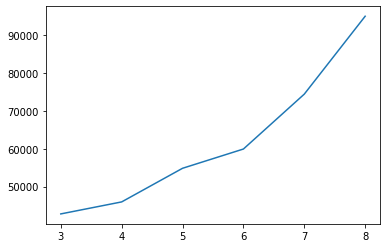

In [7]:
data_months = data.resample('1M').sum()
data_months['month'] = data_months.index.month
plt.plot(data_months['month'], data_months['num_orders'])

C марта по август количество заказов значительно выросло. Правда достоверно понять только по данным датасэта, с чем это связано, не получится.

<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='green'>Отличное замечание. Да, у нас есть только количество заказов, других признаков, влияющих на ситуацию нет. Приходится выкручиваться, анализировать и создавать свои признаки 

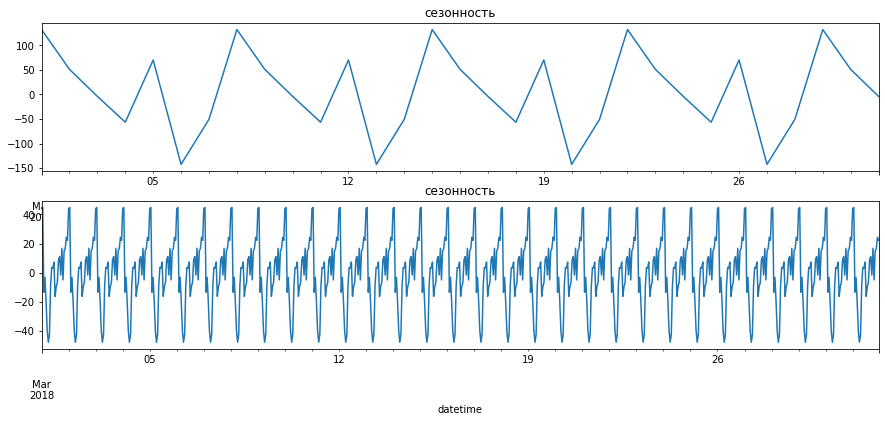

In [8]:
plt.figure(figsize=(15, 6))

# Сезонность внутри недели
decomposed = seasonal_decompose(data['2018-03-01':'2018-03-31'].resample('1D').sum().loc[:, 'num_orders'])
plt.subplot(211)
plt.title('сезонность')
decomposed.seasonal.plot(ax=plt.gca())

# Сезонность внутри суток
decomposed = seasonal_decompose(data['2018-03-01':'2018-03-31'].loc[:, 'num_orders'])
plt.subplot(212)
plt.title('сезонность')
decomposed.seasonal.plot(ax=plt.gca())

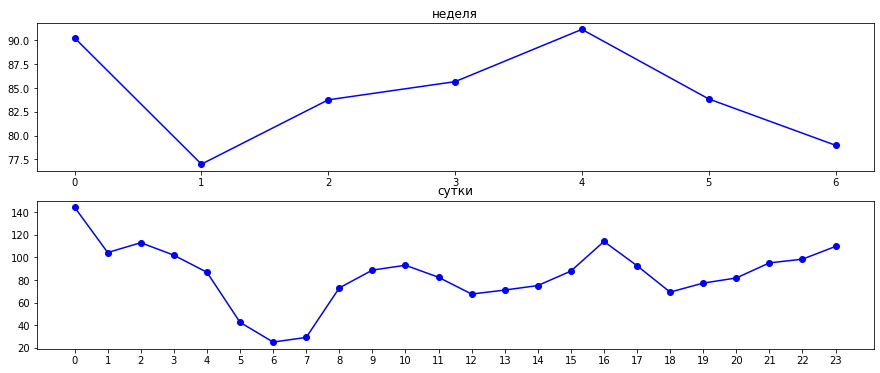

In [9]:
plt.figure(figsize=(15, 6))
plt.grid(False)

# Также построю график недели и суток
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour
typical_week = data.groupby('dayofweek')['num_orders'].mean()
plt.subplot(211)
plt.title('неделя')
plt.xticks(range(0, 7, 1))
plt.plot(typical_week.index, typical_week.values, 'bo-')

typical_day = data.groupby('hour')['num_orders'].mean()
plt.subplot(212)
plt.title('сутки')
plt.xticks(range(0, 24, 1))
plt.plot(typical_day.index, typical_day.values, 'bo-')

Виден рост числа заказов из месяца в месяц. Тренд также показывает, что временной ряд не является стационарным.
Внутри недели и внутри суток явно видна "сезонность".
Дополнительно для анализа сезонности построил графики недели и суток. На графиках присутствуют ожидаемые и очевидные закономерности.

<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='green'>Правильное замечание по поводу сезонности!\
Ряд все-таки более-менее стационарный, проверить мы это можем с помощью расширенного теста Дики-Фуллера:

4 версии теста:

Без константы и тренда: 'nc' \
С константой, но без тренда: 'c' \
С константой и линейным трендом: 'ct' \
С константой, линейным и квадратичным трендом: 'ctt'

In [10]:
# код ревьювера
from statsmodels.tsa.stattools import adfuller

ts = data['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')

Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


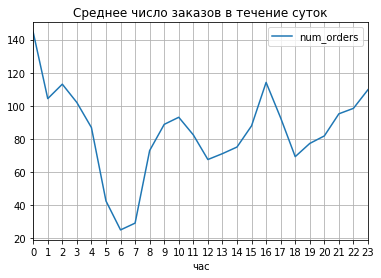

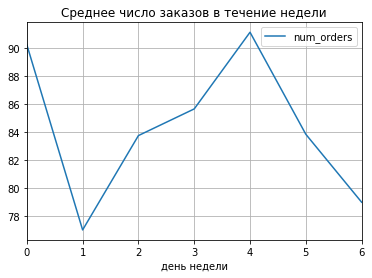

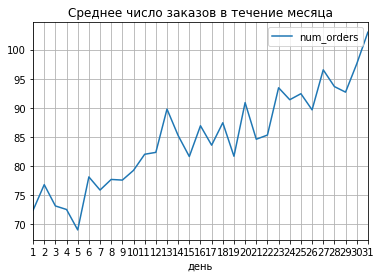

In [11]:
groupped = pd.pivot_table(data, values='num_orders', index=data.index.hour, aggfunc='mean') 
groupped.plot()
plt.title('Среднее число заказов в течение суток')
plt.xlabel('час')
plt.xticks(range(24))
plt.grid()
plt.show()

groupped = pd.pivot_table(data, values='num_orders', index=data.index.dayofweek, aggfunc='mean') 
groupped.plot()
plt.title('Среднее число заказов в течение недели')
plt.xlabel('день недели')
plt.xticks(range(7))
plt.grid()
plt.show()

groupped = pd.pivot_table(data, values='num_orders', index=data.index.day, aggfunc='mean') 
groupped.plot()
plt.title('Среднее число заказов в течение месяца')
plt.xlabel('день')
plt.xticks(range(1, 32))
plt.grid()
plt.show()

По первому графику видно, что самый высокий спрос - около полуночи и в 16 часов, самый низкий - с 5 до 7 утра. По второму - что чаще всего заказывают такси в понедельник и пятницу, реже - во вторник, от вторника и до пятницы наблюдается увеличение числа закзаов. По третьему - что в среднем такси заказывают реже всего в первых числах месяца, чем дальше - тем чаще (с пиками, связанными с днем недели)

# 3. Обучение

In [12]:
def get_xy(data):
    global train_features
    global valid_features
    global test_features
    global train_target
    global valid_target
    global test_target
    global train
    global valid
    global test
    
    train, test = train_test_split(data, shuffle=False, test_size=0.2)
    test, valid = train_test_split(test, shuffle=False, test_size=0.5)
    train = train.dropna()

    train_features = train.drop('num_orders', axis = 1)
    valid_features = valid.drop(['num_orders'], axis=1)
    test_features = test.drop('num_orders', axis = 1)
    train_target = train['num_orders']
    valid_target = valid['num_orders']
    test_target = test['num_orders']


In [13]:
%%time

compare = []
columns = ['model', 'model_params', 'features_params', 'test_rmse']

for max_lag in range(5, 16, 5):
    for rolling_mean_size in range(5, 16, 5):
        make_features(data, max_lag, rolling_mean_size)
        get_xy(data)
        
        #DecisionTreeRegressor
        for max_depth in range(10, 31, 10):
            model = DecisionTreeRegressor(max_depth = max_depth, random_state = RANDOM_STATE)
            model.fit(train_features, train_target)
            valid_pred = model.predict(valid_features)
            rmse = mean_squared_error(valid_pred, valid_target)**0.5
            compare.append(['Tree', 'max_depth = {}'.format(max_depth),
                            'max_lag = {}, r_m_size = {}'.format(max_lag,rolling_mean_size), rmse])
        #Forest
        for n_estimators in range(5, 26, 10):
            model = RandomForestRegressor(n_estimators = n_estimators, random_state = RANDOM_STATE)
            model.fit(train_features, train_target)
            valid_pred = model.predict(valid_features)
            rmse = mean_squared_error(valid_pred, valid_target)**0.5
            compare.append(['Forest', 'n_estimators = {}'.format(n_estimators),
                            'max_lag = {}, r_m_size = {}'.format(max_lag,rolling_mean_size), rmse])
 
    
        #LinearRegression
        model = LinearRegression(n_jobs = -1)
        model.fit(train_features, train_target)
        valid_pred = model.predict(valid_features)
        rmse = mean_squared_error(valid_pred, valid_target)**0.5
        compare.append(['LinearRegression', '-',
                            'max_lag = {}, r_m_size = {}'.format(max_lag,rolling_mean_size), rmse])

results = pd.DataFrame(data = compare, columns = columns)
results.sort_values('test_rmse', ascending = True).head(10)        

CPU times: user 14.1 s, sys: 521 ms, total: 14.6 s
Wall time: 14.8 s


,model,model_params,features_params,test_rmse
61,Forest,n_estimators = 25,"max_lag = 15, r_m_size = 15",49.873607
59,Forest,n_estimators = 5,"max_lag = 15, r_m_size = 15",50.077112
60,Forest,n_estimators = 15,"max_lag = 15, r_m_size = 15",50.225379
39,Forest,n_estimators = 15,"max_lag = 10, r_m_size = 15",50.484850
38,Forest,n_estimators = 5,"max_lag = 10, r_m_size = 15",50.494298
40,Forest,n_estimators = 25,"max_lag = 10, r_m_size = 15",50.658839
54,Forest,n_estimators = 25,"max_lag = 15, r_m_size = 10",51.766540
53,Forest,n_estimators = 15,"max_lag = 15, r_m_size = 10",52.564930
25,Forest,n_estimators = 15,"max_lag = 10, r_m_size = 5",52.848101
18,Forest,n_estimators = 15,"max_lag = 5, r_m_size = 15",53.252426


Явно лидирует Лес, лучший показатель у модели с n_estimators = 25, обученной на признаках со следующими параметрами: max_lag = 15, rolling_mean_size = 15. RMSE у нее примерно 49. Попробуем проварьировать параметры для Леса, чтобы выжать еще больше.

<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='green'>А вот и признак со средним, но есть нюансы\
<font color='red'>
   
1. У тебя скользящее среднее учитывает текущее значение ряда, что неверно, так как происходит утечка целевого признака.
2. Получается, ты подгоняешь параметр (значение rolling) под все данные. Нет деления на обучающую, валидационную и тестовую выборку. Добавь, пожалуйста

In [14]:
forest = []
columns = ['model_params', 'features_params', 'test_rmse']

for max_lag in range(1, 30, 5):
    for rolling_mean_size in range(1, 30, 5):
        
        #create features
        make_features(data, max_lag, rolling_mean_size)
        #split
        get_xy(data)
        
        #Forest
        for n_estimators in range(5, 100, 10):
            model = RandomForestRegressor(n_estimators = n_estimators, random_state = RANDOM_STATE)
            model.fit(train_features, train_target)
            test_pred = model.predict(valid_features)
            rmse = mean_squared_error(test_pred, valid_target)**0.5
            forest.append(['n_estimators = {}'.format(n_estimators),
                            'max_lag = {}, r_m_size = {}'.format(max_lag,rolling_mean_size), rmse])
            
forests_results = pd.DataFrame(data = forest, columns = columns)
forests_results.sort_values('test_rmse', ascending = True).head(10)

,model_params,features_params,test_rmse
322,n_estimators = 25,"max_lag = 26, r_m_size = 11",48.522345
231,n_estimators = 15,"max_lag = 16, r_m_size = 26",48.708372
321,n_estimators = 15,"max_lag = 26, r_m_size = 11",48.819736
323,n_estimators = 35,"max_lag = 26, r_m_size = 11",48.857958
324,n_estimators = 45,"max_lag = 26, r_m_size = 11",49.077873
233,n_estimators = 35,"max_lag = 16, r_m_size = 26",49.085465
326,n_estimators = 65,"max_lag = 26, r_m_size = 11",49.152714
236,n_estimators = 65,"max_lag = 16, r_m_size = 26",49.192293
327,n_estimators = 75,"max_lag = 26, r_m_size = 11",49.224429
237,n_estimators = 75,"max_lag = 16, r_m_size = 26",49.227837


Остановимся на n_estimators = 25, max_lag = 26, rolling_mean_size = 11. При этом чем больше n_estimators, тем лучше RMSE, однако гнаться за десятыми долями процентов - опасно, модель может переобучиться.

<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='red'>Здесь как раз можно предсказывать на валидационной выборке, чтобы потом выбирать лучшую модель

# 4. Тестирование

Проверю горизонт планирования у обученных модели.

<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='orange'>Хорошо, что в итоге ты добавляешь деление и не учишь модели на валидации и тесте. Однако от такого позднего деления смысл валидационной выборки немного теряется. Она нам нужна, чтобы на ней как раз смотреть метрику и подбирать гиперпараметры, а потом выбирать лучшую модель. Выбрав такую, проверяем на тестовой выборке 

In [15]:
make_features(data, 26, 11)
get_xy(data)

model = RandomForestRegressor(n_estimators = 55, random_state = RANDOM_STATE)
model.fit(train_features, train_target)
test_pred = model.predict(test_features)
rmse = mean_squared_error(test_pred, test_target)**0.5
print('RMSE полученной модели:', rmse)

RMSE полученной модели: 32.101714386687384


Измерим качество предсказания временных рядов и проверим модель на адекватность. Спрогнозируем временной ряд без обучения двумя способами:

* Все значения тестовой выборки предсказываются одним и тем же числом (медианой). 
* Новое значение x(t) прогнозируется предыдущим значением ряда, то есть x(t-1).

In [16]:
pred_median = np.ones(len(test)) * train['num_orders'].median()
print("RMSE медианной модели:",  mean_squared_error(pred_median,test['num_orders'])**0.5)

pred_previous = test['num_orders'].shift()
pred_previous.iloc[0] = train['num_orders'].iloc[-1]

print("RMSE отстающей модели:",  mean_squared_error(pred_previous,test['num_orders'])**0.5)

RMSE медианной модели: 59.68095795210938
RMSE отстающей модели: 47.246345832986236


Второй вариант модели без обучения справляется лучше медианного, но наша модель сильно превосходит их обе, а значит проверка на адекватность пройдена

### Вывод
Лучший показатель RMSE у модели Леса. Получил требуемую точность (не больше 48) 

<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='red'>Добавь, пожалуйста, выводы по проекту

<font color='blue'><b>Комментарий ревьювера v2</b></font> \
<font color='green'>Хорошо :)

<font color='blue'><b>Итоговый комментарий ревьювера</b></font>\
<font color='green'>Олег, проделана серьезная работа! Понравилось, что данные подготовлены и визуализированы правильно, есть отличные выводы по этим этапам.</font>

<font color='blue'>Что можно сделать лучше:</font>
<ul><font color='red'>1) Устранить утечку целевого признака в скользящем среднем; использовать не текущее, а предыдущее значение ряда</font></ul>
<ul><font color='red'>2) Сделать деление выборки на три части пораньше, использовать валидацию для подбора различных параметров</font></ul>
<ul><font color='red'>3) Написать итоговый вывод по проекту</font></ul>
<ul><font color='orange'>4) Добавить отстающий тип признаков (lag) - по желанию</font></ul>

<font color='blue'><b>Спасибо, жду твоих исправлений и комментариев!</b></font>

<font color='blue'><b>Итоговый комментарий ревьювера v2</b></font>\
<font color='green'>Олег, спасибо, что постарался учесть мои комментарии.</font>\
<font color='red'>Однако, я не понял, почему ты удалил валидацию совсем. У тебя было правильно деление 80%-10%-10%, просто надо было его использовать на подборе параметров (у тебя это ячейки 13 и 14). Предсказание там должно быть на valid выборке. А test (последние 10%) используются только в шаге 4 (ячейка 15)</font>\
<font color='blue'>
Ты также можешь попробовать не деление выборки на три части, а кросс-валидацию на основе обучающей (тест в любом случае остается в шаге 4). Кросс-валидация временного ряда отличается от обычной\
В случае с временным рядом нам нужно задать кросс-валидацию TimeSeriesSplit\
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html \
Если мы исследуем временной ряд, то в каждом сплите тестовые индексы должны быть позже по времени, чем обучающие, поэтому перетасовка обычным способом неуместна. Как раз TimeSeriesSplit решает эту проблему.\
Иллюстрация работы:

![image.png](https://scikit-learn.org/dev/_images/sphx_glr_plot_cv_indices_010.png)

Код реализации:
<code>
tscv = TimeSeriesSplit(n_splits=2)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search)
gsearch.fit(X, y)</code></font>
    
    
    
    
<font color='blue'><b>До скорой встречи!</b></font>

<font color='blue'><b>Итоговый комментарий ревьювера v3</b></font>\
<font color='green'>Олег, теперь все отлично\
Поздравляю, проект принят! Успехов :)

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48